In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

from sklearn.metrics.pairwise import cosine_similarity

from ast import literal_eval

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
# md = movie dataset
md_rating_small = pd.read_csv('ratings_small.csv')
md_meta = pd.read_csv('movies_metadata.csv')
md_link_small = pd.read_csv('links_small.csv')
md_terpilih = pd.read_csv('data_cleaning.csv',sep=',')

In [5]:
md_terpilih['release_date'] = pd.to_datetime(md_terpilih['release_date'])
md_terpilih.drop(columns=['Unnamed: 0'],inplace=True)
print("sebelum drop duplicate: ",md_terpilih.shape)
md_terpilih.drop_duplicates(subset=['title'], inplace=True)
print("Sesudah drop duplicate: ",md_terpilih.shape)

sebelum drop duplicate:  (45548, 22)
Sesudah drop duplicate:  (41292, 22)


In [6]:
md_terpilih.head(2)

,id,poster_path,title,vote_average,vote_count,weighted_rating,popularity,budget,revenue,runtime,genre_new,lang_new,name_companies,name_country,cast_name,director_name,overview,words,release_date,year,month,day
0,862,https://image.tmdb.org/t/p/original/rhIRbceoE9...,Toy Story,7.7,5415.0,7.640091,21.946943,30000000,373554033.0,81.0,"['Animation', 'Comedy', 'Family']",['English'],['PixarAnimationStudios'],['UnitedStatesofAmerica'],"['TomHanks', 'TimAllen', 'DonRickles', 'JimVar...",['JohnLasseter'],"Led by Woody, Andy's toys live happily in his ...","['jealousy', 'toy', 'boy', 'friendship', 'frie...",1995-10-30,1995,10,30
1,8844,https://image.tmdb.org/t/p/original/vzmL6fP7aP...,Jumanji,6.9,2413.0,6.820579,17.015539,65000000,262797249.0,104.0,"['Adventure', 'Fantasy', 'Family']","['English', 'Français']","['TriStarPictures', 'TeitlerFilm', 'Interscope...",['UnitedStatesofAmerica'],"['RobinWilliams', 'JonathanHyde', 'KirstenDuns...",['JoeJohnston'],When siblings Judy and Peter discover an encha...,"['board game', 'disappearance', ""based on chil...",1995-12-15,1995,12,15


In [7]:
md_terpilih.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41292 entries, 0 to 45547
Data columns (total 22 columns):
id                 41292 non-null int64
poster_path        41292 non-null object
title              41292 non-null object
vote_average       41292 non-null float64
vote_count         41292 non-null float64
weighted_rating    41292 non-null float64
popularity         41292 non-null float64
budget             41292 non-null int64
revenue            41292 non-null float64
runtime            41292 non-null float64
genre_new          41292 non-null object
lang_new           41292 non-null object
name_companies     41292 non-null object
name_country       41292 non-null object
cast_name          41292 non-null object
director_name      41292 non-null object
overview           41292 non-null object
words              41292 non-null object
release_date       41292 non-null datetime64[ns]
year               41292 non-null int64
month              41292 non-null int64
day                4

In [8]:
md_terpilih = md_terpilih.sort_values('release_date', ascending=False)

**<font style="color:#1CAD8A;"># Export md_terpilih to Pickle</font>**

In [9]:
# https://www.datacamp.com/community/tutorials/pickle-python-tutorial
# perintah export pickle
filename = 'md_terpilih.sav'
outfile = open(filename,'wb')
pickle.dump(md_terpilih, outfile)
outfile.close()

# Demographic Filtering

## ==== Based On Weight Rating ====

**rumus weight rating (WR)**

$$ WR = (v / (v+m))*R + (m / (v+m))*C $$

- v adalah jumlah vote dalam sebuah movie
- m is jumlah vote minimum untuk sebuah movie agar dapat masuk dalam list
- R is nilai rating rata2 sebuah film
- C is the mean vote across the whole report

In [10]:
md_meta.shape

(45466, 24)

In [11]:
md_terpilih.shape

(41292, 22)

In [12]:
m = md_meta['vote_count'].quantile(0.95)
C = md_meta['vote_average'].mean()

In [13]:
df_top_movie = md_terpilih.copy().loc[md_terpilih['vote_count'] >= m]
df_top_movie.shape

(2096, 22)

In [14]:
df_top_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 44751 to 1903
Data columns (total 22 columns):
id                 2096 non-null int64
poster_path        2096 non-null object
title              2096 non-null object
vote_average       2096 non-null float64
vote_count         2096 non-null float64
weighted_rating    2096 non-null float64
popularity         2096 non-null float64
budget             2096 non-null int64
revenue            2096 non-null float64
runtime            2096 non-null float64
genre_new          2096 non-null object
lang_new           2096 non-null object
name_companies     2096 non-null object
name_country       2096 non-null object
cast_name          2096 non-null object
director_name      2096 non-null object
overview           2096 non-null object
words              2096 non-null object
release_date       2096 non-null datetime64[ns]
year               2096 non-null int64
month              2096 non-null int64
day                2096 non-null int64


In [15]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    hasil = (v/(v+m)) * R + (m/(v+m)) * C
    return hasil

In [16]:
df_top_movie['weight_rating'] = df_top_movie.apply(weighted_rating, axis=1)

In [17]:
ha = df_top_movie[df_top_movie['id']==278]
print(ha['title'].iloc[0])
ha

The Shawshank Redemption


,id,poster_path,title,vote_average,vote_count,weighted_rating,popularity,budget,revenue,runtime,genre_new,lang_new,name_companies,name_country,cast_name,director_name,overview,words,release_date,year,month,day,weight_rating
312,278,https://image.tmdb.org/t/p/original/9O7gLzmreU...,The Shawshank Redemption,8.5,8358.0,8.445574,51.645403,25000000,28341469.0,142.0,"['Drama', 'Crime']",['English'],"['CastleRockEntertainment', 'WarnerBros.']",['UnitedStatesofAmerica'],"['TimRobbins', 'MorganFreeman', 'BobGunton', '...",['FrankDarabont'],Framed in the 1940s for the double murder of h...,"['prison', 'corruption', 'police brutality', '...",1994-09-23,1994,9,23,8.357746


**<font style="color:#1CAD8A;"># Export df_top_movie to Pickle</font>**

In [18]:
# https://www.datacamp.com/community/tutorials/pickle-python-tutorial
# perintah export pickle
filename = 'df_top_movie.sav'
outfile = open(filename,'wb')

pickle.dump(df_top_movie, outfile)
outfile.close()

## based on popularity

In [19]:
md_terpilih['popularity'] = md_terpilih['popularity'].apply(lambda x : float(x))

In [20]:
top_ten_pop = md_terpilih.sort_values(by='popularity', ascending=False)[['id', 'poster_path','title', 'popularity']]

In [21]:
# export to pickle
top_ten_pop

filename = 'df_top_ten.sav'
outfile = open(filename,'wb')

pickle.dump(top_ten_pop, outfile)
outfile.close()

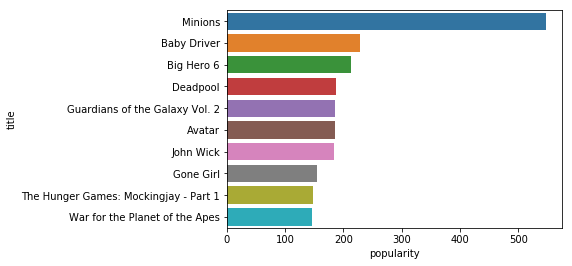

In [22]:
sns.barplot(data=top_ten_pop.head(10), x='popularity', y='title', orient='h')

# Content Based

## based on genre

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

In [24]:
cb_genres = md_terpilih[md_terpilih['vote_count']>300]

In [25]:
cv_genre = CountVectorizer() 
trans_genre = cv_genre.fit_transform(cb_genres['genre_new'])

In [26]:
df_sim_genre = pd.DataFrame(trans_genre.todense(),
                     columns=cv_genre.get_feature_names(),index=cb_genres['title'])

In [27]:
cos_sim_genre = cosine_similarity(trans_genre)

In [28]:
sim_score_genre = pd.DataFrame(cos_sim_genre, index=cb_genres['title'], columns=cb_genres['title'])

In [29]:
def rec_genre(title):
    simpan = sim_score_genre[title].sort_values(ascending=False)
    simpan = simpan.drop(index=[title])
    print(simpan.head(10))

In [30]:
rec_genre('Toy Story')

title
Surf's Up                              1.0
Hotel Transylvania 2                   1.0
The Great Mouse Detective              1.0
Oliver & Company                       1.0
Hop                                    1.0
Garfield: A Tail of Two Kitties        1.0
Looney Tunes: Back in Action           1.0
Cloudy with a Chance of Meatballs 2    1.0
The Simpsons Movie                     1.0
The Boss Baby                          1.0
Name: Toy Story, dtype: float64


**<font style="color:#1CAD8A;"># Export sim_score_genre to Pickle</font>**

In [31]:
# https://www.datacamp.com/community/tutorials/pickle-python-tutorial
# perintah export pickle
filename = 'df_sim_score_genre.sav'
outfile = open(filename,'wb')

pickle.dump(sim_score_genre, outfile)
outfile.close()

### based on keywords

In [32]:
cv3 = CountVectorizer() 
cv_key_result = cv3.fit_transform(cb_genres['words'])

In [33]:
cos_sim_key = cosine_similarity(cv_key_result)

In [34]:
df_key_rec = pd.DataFrame(cos_sim_key, index=cb_genres['title'], columns=cb_genres['title'])

In [35]:
def rec_key(title):
    simpan = df_key_rec[title].sort_values(ascending=False)
    simpan = simpan.drop(index=[title])
    print(simpan.head(10))

simpan = df_key_rec['Toy Story'].sort_values(ascending=False)
simpan = simpan.drop(index=['Toy Story'])
df_head = simpan.head(10)

In [36]:
df_head

title
Small Soldiers                    0.559503
Toy Story 3                       0.508168
Child's Play 2                    0.442326
Ted                               0.440086
Child's Play                      0.430528
Pinocchio                         0.373002
Toy Story 2                       0.348481
Curse of Chucky                   0.346989
Ted 2                             0.346989
Mr. Magorium's Wonder Emporium    0.323029
Name: Toy Story, dtype: float64

In [37]:
val_title_idx = pd.DataFrame(df_head).index
df_head = pd.DataFrame({
    'title' : val_title_idx
})

In [38]:
df_head

,title
0,Small Soldiers
1,Toy Story 3
2,Child's Play 2
3,Ted
4,Child's Play
5,Pinocchio
6,Toy Story 2
7,Curse of Chucky
8,Ted 2
9,Mr. Magorium's Wonder Emporium


In [39]:
pd.merge(md_terpilih, df_head, on='title', how='right')

,id,poster_path,title,vote_average,vote_count,weighted_rating,popularity,budget,revenue,runtime,genre_new,lang_new,name_companies,name_country,cast_name,director_name,overview,words,release_date,year,month,day
0,214756,https://image.tmdb.org/t/p/original/A7HtCxFe7M...,Ted 2,6.2,2524.0,6.166080,42.061481,68000000,2.170226e+08,115.0,['Comedy'],['English'],"['UniversalPictures', 'FuzzyDoorProductions', ...",['UnitedStatesofAmerica'],"['MarkWahlberg', 'SethMacFarlane', 'AmandaSeyf...",['SethMacFarlane'],Newlywed couple Ted and Tami-Lynn want to have...,"['sperm bank', 'sequel', 'buddy', 'courthouse'...",2015-06-25,2015,6,25
1,167032,https://image.tmdb.org/t/p/original/qoFfZa6b9x...,Curse of Chucky,5.6,417.0,5.610518,15.771245,5000000,0.000000e+00,97.0,"['Horror', 'Thriller']",['English'],['Universal1440Entertainment'],['UnitedStatesofAmerica'],"['BradDourif', 'BrennanElliott', 'AMartinez', ...",['DonMancini'],"After the passing of her mother, a young woman...","['wheelchair', 'horror', 'killer doll', 'escap...",2013-10-04,2013,10,4
2,72105,https://image.tmdb.org/t/p/original/yLdP2vDa1B...,Ted,6.3,4811.0,6.278421,19.638605,50000000,5.493683e+08,106.0,"['Comedy', 'Fantasy']",['English'],"['UniversalPictures', 'MediaRightsCapital', 'F...",['UnitedStatesofAmerica'],"['MarkWahlberg', 'MilaKunis', 'SethMacFarlane'...",['SethMacFarlane'],"John Bennett, a man whose childhood wish of br...","['friendship', 'love', 'teddy bear', 'toy come...",2012-06-29,2012,6,29
3,10193,https://image.tmdb.org/t/p/original/mMltbSxwEd...,Toy Story 3,7.6,4710.0,7.534747,16.966470,200000000,1.066970e+09,103.0,"['Animation', 'Family', 'Comedy']","['English', 'Español']","['WaltDisneyPictures', 'PixarAnimationStudios']",['UnitedStatesofAmerica'],"['TomHanks', 'TimAllen', 'NedBeatty', 'JoanCus...",['LeeUnkrich'],"Woody, Buzz, and the rest of Andy's toys haven...","['hostage', 'college', 'toy', 'barbie', 'anima...",2010-06-16,2010,6,16
4,2284,https://image.tmdb.org/t/p/original/75m4IBZE6g...,Mr. Magorium's Wonder Emporium,6.0,365.0,5.888595,8.696467,0,6.947466e+07,93.0,['Comedy'],['English'],"['MandatePictures', 'FilmColony', 'WaldenMedia...","['Canada', 'UnitedStatesofAmerica']","['DustinHoffman', 'NataliePortman', 'JasonBate...",['ZachHelm'],Molly Mahoney is the awkward and insecure mana...,"['magic', 'fantasy', 'darkness', 'toy', 'sell'...",2007-11-14,2007,11,14
5,863,https://image.tmdb.org/t/p/original/3CmK3XurcL...,Toy Story 2,7.3,3914.0,7.233928,17.547693,90000000,4.973669e+08,92.0,"['Animation', 'Comedy', 'Family']",['English'],['PixarAnimationStudios'],['UnitedStatesofAmerica'],"['TomHanks', 'TimAllen', 'JoanCusack', 'Kelsey...",['JohnLasseter'],"Andy heads off to Cowboy Camp, leaving his toy...","['museum', 'prosecution', 'identity crisis', '...",1999-10-30,1999,10,30
6,11551,https://image.tmdb.org/t/p/original/l5laJWvcxg...,Small Soldiers,6.2,522.0,6.066798,10.039360,40000000,5.468255e+07,110.0,"['Comedy', 'Adventure', 'Fantasy', 'Science Fi...","['English', 'Français', 'Magyar', 'Español']","['UniversalPictures', 'AmblinEntertainment', '...",['UnitedStatesofAmerica'],"['GregorySmith', 'KirstenDunst', 'DenisLeary',...",['JoeDante'],When missile technology is used to enhance toy...,"['defense industry', 'toy shop', 'technical to...",1998-07-10,1998,7,10
7,11186,https://image.tmdb.org/t/p/original/xy0qUntbDO...,Child's Play 2,5.8,323.0,5.745752,14.310479,13000000,3.576360e+07,84.0,"['Drama', 'Horror']","['English', 'Türkçe']",['UniversalPictures'],['UnitedStatesofAmerica'],"['AlexVincent', 'JennyAgutter', 'GerritGraham'...",['JohnLafia'],Chuckie's back as the doll possessed by the so...,"['faithlessness', 'puppet', 'killer toys', 'to...",1990-11-09,1990,11,9
8,10585,https://image.tmdb.org/t/p/original/dSX9i2buib...,Child's Play,6.3,605.0,6.160091,19.827546,9000000,4.419668e+07,87.0,"['Horror', 'Thriller']",['English'],['UnitedArtists'],['UnitedStatesofAmerica'],"['CatherineHicks', 'ChrisSarandon', 'AlexVince...",['TomHolland'],A single mother gives her son

In [40]:
rec_key('Toy Story')

title
Small Soldiers                    0.559503
Toy Story 3                       0.508168
Child's Play 2                    0.442326
Ted                               0.440086
Child's Play                      0.430528
Pinocchio                         0.373002
Toy Story 2                       0.348481
Curse of Chucky                   0.346989
Ted 2                             0.346989
Mr. Magorium's Wonder Emporium    0.323029
Name: Toy Story, dtype: float64


In [41]:
# perintah export pickle
filename = 'df_sim_score_keywords.sav'
outfile = open(filename,'wb')

pickle.dump(df_key_rec, outfile)
outfile.close()

### Based on Cast and director

In [42]:
cv4 = CountVectorizer() 
cv_cast = cv4.fit_transform(cb_genres['cast_name'])

cv5 = CountVectorizer() 
cv_director = cv5.fit_transform(cb_genres['director_name'])

In [43]:
cos_sim_cast = cosine_similarity(cv_cast)
cos_sim_director = cosine_similarity(cv_director)

In [44]:
score_sim_gabung = (cos_sim_cast*0.7) + (cos_sim_director*0.3)

In [45]:
df_gabung_rec = pd.DataFrame(score_sim_gabung, index=cb_genres['title'], columns=cb_genres['title'])

In [46]:
def rec_gabung(title):
    simpan = df_gabung_rec[title].sort_values(ascending=False)
    simpan = simpan.drop(index=[title])
    print(simpan.head(10))

In [47]:
rec_gabung('Toy Story')

title
Toy Story 2                    0.696297
Cars                           0.382369
A Bug's Life                   0.347087
Cars 2                         0.328319
Toy Story 3                    0.257626
The Polar Express              0.061394
The Texas Chainsaw Massacre    0.058537
The Santa Clause               0.058537
A Hologram for the King        0.056045
The Incredibles                0.056045
Name: Toy Story, dtype: float64


In [48]:
# perintah export pickle
filename = 'df_sim_gabung_CastDirector.sav'
outfile = open(filename,'wb')

pickle.dump(df_gabung_rec, outfile)
outfile.close()

# Collaborative Filtering

In [49]:
md_rating = pd.read_csv('ratings_small.csv')

In [50]:
md_rating['timestamp'] = pd.to_datetime(md_rating['timestamp'], unit='s')

In [51]:
print("shape rating : ", md_rating.shape)
print("shape data :   ", md_terpilih.shape)

shape rating :  (100004, 4)
shape data :    (41292, 22)


In [52]:
md_rating.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59


In [53]:
md_rating.rename(columns={'movieId' : 'id'}, inplace=True)

In [54]:
md_rating.head(2)

,userId,id,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59


In [55]:
user = pd.merge(md_terpilih, md_rating, on='id', how='right')
user = user[['id', 'userId','title','rating']]
user.head()

,id,userId,title,rating
0,86835,176,Knight of Cups,2.0
1,86835,213,Knight of Cups,3.0
2,86835,268,Knight of Cups,1.5
3,86835,615,Knight of Cups,1.5
4,189,564,Sin City: A Dame to Kill For,4.0


In [56]:
print('sebelum di merger: ', md_terpilih.shape)
print('sebelum di merger: ', md_rating.shape)
print('hasil merge: ',user.shape)
user.dropna(inplace=True)
print('hasil droppna: ',user.shape)

sebelum di merger:  (41292, 22)
sebelum di merger:  (100004, 4)
hasil merge:  (100004, 4)
hasil droppna:  (42691, 4)


In [57]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42691 entries, 0 to 42690
Data columns (total 4 columns):
id        42691 non-null int64
userId    42691 non-null int64
title     42691 non-null object
rating    42691 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.6+ MB


In [58]:
user_pivot = user.pivot_table(columns='userId', index='title', values='rating')
print("user_pivot_shape: ",user_pivot.shape)
user_pivot.dropna(thresh=5, inplace=True) # film yang mendapat minal 5 rate
user_pivot.fillna(0,inplace=True)
print("user_pivot_shape affter thresh: ",user_pivot.shape)

user_pivot_shape:  (2657, 671)
user_pivot_shape affter thresh:  (1294, 671)


In [59]:
cos_sim_cf_item = cosine_similarity(user_pivot) # menhasilkan hubungan userid dan film
df_sim_user_movie = pd.DataFrame(cos_sim_cf_item, columns=user_pivot.index, index=user_pivot.index)

In [60]:
def rec_item(user_rated_movie):
    sum_movie_score = df_sim_user_movie['Titanic']*(0)
    judul=[]
    for item in user_rated_movie:
        sum_movie_score += df_sim_user_movie[item[0]] * (item[1]-2.5)
        judul.append(item[0])
    hai = sum_movie_score.sort_values(ascending=False)
    hai.drop(index=judul, inplace=True)
    return hai.head(10)

In [61]:
user_1 = [['Titanic', 2], ['A Perfect Murder', 5]]

In [62]:
rec_item(user_1)

title
Cold Mountain              1.111590
Aelita: Queen of Mars      1.066985
Prime                      1.024644
Yella                      0.992567
Lonely Hearts              0.971798
Payback                    0.959759
While You Were Sleeping    0.935344
8 Women                    0.922429
Superman                   0.920909
24 Hour Party People       0.909247
Name: Titanic, dtype: float64

In [63]:
# perintah export pickle
filename = 'df_sim_item_based.sav'
outfile = open(filename,'wb')

pickle.dump(df_sim_user_movie, outfile)
outfile.close()

## user based CF

In [64]:
md_rating_small.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [65]:
md_rating_small.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [66]:
df_pivot_user = md_rating_small.pivot_table(index='userId', columns='movieId', values='rating')
df_pivot_user = df_pivot_user.dropna(thresh=30).fillna(0)
cos_sim_cf_user = cosine_similarity(df_pivot_user) # menhasilkan hubungan userid dan film
df_sim_cf_user = pd.DataFrame(cos_sim_cf_user, index=df_pivot_user.index, columns=df_pivot_user.index)

In [67]:
# misal
df_pivot_user.loc[5].sort_values(ascending=False).head()

movieId
597      5.0
2081     5.0
1035     5.0
1380     5.0
33166    5.0
Name: 5, dtype: float64

In [68]:
new_user = [[265,5],[266,5],[592,5],[590,5],[589,5]]

In [69]:
# contoh input data
df_pivot_user.loc[ df_pivot_user.index[-1] + 1, [265,266,592,590,589]] = [3,4,5,5,5]
df_pivot_user.fillna(0,inplace=True)

In [70]:
df_pivot_user.index[-1]

672

In [71]:
df_pivot_user.loc[df_pivot_user.index[-1], [265,266,592,590,589]]

movieId
265    3.0
266    4.0
592    5.0
590    5.0
589    5.0
Name: 672, dtype: float64

In [72]:
sim_user_again = cosine_similarity(df_pivot_user)

user_id_similar = pd.DataFrame(sim_user_again,
                               columns=df_pivot_user.index,
                               index=df_pivot_user.index)

halo = user_id_similar[df_pivot_user.index[-1]].sort_values(ascending=False)[1:11].index

serr = []
for id in halo:
#     print(id)
    movie_rating = df_pivot_user.loc[id]
    serr.append(movie_rating)

In [73]:
movie_id_user = (sum(serr)/10).sort_values(ascending=False).head(20)

In [74]:
movie_id_user

movieId
590    4.4
589    4.2
480    4.1
356    3.5
457    3.3
588    3.3
377    3.2
592    3.2
150    3.0
593    3.0
165    2.9
364    2.8
527    2.6
587    2.5
316    2.5
110    2.5
380    2.4
47     2.3
296    2.3
595    2.2
dtype: float64

In [75]:
len([])

0

In [81]:
i=0
for item in movie_id_user.index:
    our_rec = md_terpilih[md_terpilih['id'] == item]['title'].values
    if(len(our_rec)!=0):
        print(md_terpilih[md_terpilih['id'] == item]['title'].values[0])
        i+=1
        if(i>=10):
            break
    
# md_terpilih[md_terpilih['id'] == 265]['title'].values[0]

The Hours
Monsoon Wedding
Sissi
Silent Hill
A Nightmare on Elm Street
The Conversation
48 Hrs.
Solaris
Back to the Future Part II
Batman Returns


In [84]:
def get_recom_user_based(user_ratings):
    ls_id_movie=[]
    ls_rate_movie=[]
    print(df_pivot_user.index[-1])
    for item in range(len(user_ratings)):
        ls_id_movie.append(user_ratings[item][0])
        ls_rate_movie.append(user_ratings[item][1])
    df_pivot_user.loc[ df_pivot_user.index[-1] + 1, ls_id_movie] = ls_rate_movie
    df_pivot_user.fillna(0,inplace=True)
    
    sim_user_again = cosine_similarity(df_pivot_user)
    user_id_similar = pd.DataFrame(sim_user_again,
                                   columns=df_pivot_user.index,
                                   index=df_pivot_user.index)
    
    halo = user_id_similar[df_pivot_user.index[-1]].sort_values(ascending=False)[1:11].index

    serr = []
    for id in halo:
    #     print(id)
        movie_rating = df_pivot_user.loc[id]
        serr.append(movie_rating)
        
    movie_id_user = (sum(serr)/20).sort_values(ascending=False).head(20).index
    
    i=0
    for item in movie_id_user:
        our_rec = md_terpilih[md_terpilih['id'] == item]['title'].values
        if(len(our_rec)!=0):
            print(md_terpilih[md_terpilih['id'] == item]['title'].values[0])
            i+=1
            if(i>=10):
                break    

In [78]:
new_user1 = [[265,5],[266,5],[592,1],[590,2],[589,3]]
new_user2 = [[265,1],[1035,5],[592,5],[590,1],[33166,5], [589,5]]

In [85]:
#if have a new user
get_recom_user_based(new_user1)

675
Contempt
The Hours
The Conversation
Lili Marleen
A Nightmare on Elm Street
Sissi
Once Were Warriors
48 Hrs.
Monsoon Wedding
Back to the Future Part II


In [86]:
#if have a new user
get_recom_user_based(new_user2)

676
The Conversation
Contempt
The Hours
Lili Marleen
Monsoon Wedding
Sissi
Cockles and Muscles
Back to the Future Part II
Terminator 3: Rise of the Machines
Lost in Translation


# ========================================================